In [1]:
import numpy as np
import rasterio
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
def calcular_indices(imagen):
    # === Extraer y normalizar bandas ===
    blue = imagen[0].astype('float32') / 10000.0
    green = imagen[1].astype('float32') / 10000.0
    red = imagen[3].astype('float32') / 10000.0
    red_edge = imagen[4].astype('float32') / 10000.0
    nir = imagen[5].astype('float32') / 10000.0

    def safe_div(a, b):
        return np.where((b == 0) | np.isnan(a) | np.isnan(b), np.nan, a / b)

    # === NDVI ===
    ndvi = safe_div(nir - red, nir + red)

    # === ExG ===
    exg = 2 * green - red - blue

    # === GCI ===
    gci = safe_div(nir, green) - 1

    # === IREC ===
    irec = safe_div(nir - red, red_edge / nir)

    # === Reemplazar valores negativos por 0 (opcional) ===
    ndvi[ndvi < 0] = 0
    gci[gci < 0] = 0
    irec[irec < 0] = 0

    # Limitar valores anómalos
    gci[gci > 15] = np.nan
    irec[irec > 20] = np.nan

    return ndvi, exg, gci, irec

In [3]:
# === Ruta al archivo multibanda (ajusta esto a tu archivo) ===
ruta_imagen = 'Rst/Matrice_29_06_24.tif'

# === Cargar bandas como array ===
with rasterio.open(ruta_imagen) as src:
    imagen = src.read()  # imagen.shape = (6, alto, ancho)
    perfil = src.profile  # Guardamos perfil para luego guardar salidas

# === Aplicar la función que creamos ===
ndvi, exg, irec, gci = calcular_indices(imagen)

C:\Users\seflo\AppData\Local\Temp\ipykernel_32864\1169728119.py:10: RuntimeWarning: divide by zero encountered in divide
  return np.where((b == 0) | np.isnan(a) | np.isnan(b), np.nan, a / b)


In [4]:
# === Crear carpeta de salida si no existe ===
os.makedirs("Indices", exist_ok=True)

# === Diccionario con índices y nombres de archivo ===
indices = {
    "NDVI_290624": ndvi,
    "ExG_290624": exg,
    "IREC_290624": irec,
    "GCI_290624": gci
}

# === Guardar cada índice ===
for nombre, array in indices.items():
    salida = f"Indices/{nombre}.tif"
    
    perfil.update(
        dtype='float32',
        count=1,
        compress='lzw'  # Compresión ligera para reducir tamaño
    )
    
    with rasterio.open(salida, 'w', **perfil) as dst:
        dst.write(array, 1)

In [5]:
def calcular_cobertura_desde_tif(ruta_tif, umbral):
    with rasterio.open(ruta_tif) as src:
        indice = src.read(1).astype('float32')

        # Reemplazar valores nodata por NaN si existen
        if 'nodata' in src.profile and src.nodata is not None:
            indice[indice == src.nodata] = np.nan

        mascara_validos = ~np.isnan(indice)
        mascara_vegetacion = (indice > umbral) & mascara_validos

        total_validos = np.sum(mascara_validos)
        total_vegetacion = np.sum(mascara_vegetacion)

        cobertura = (total_vegetacion / total_validos) * 100 if total_validos > 0 else 0

        return cobertura

In [21]:
cobertura_ndvi = calcular_cobertura_desde_tif("Indices/NDVI_290624.tif", umbral=0.7)
cobertura_exg  = calcular_cobertura_desde_tif("Indices/ExG_290624.tif", umbral=0.05)
cobertura_irec  = calcular_cobertura_desde_tif("Indices/IREC_290624.tif", umbral=2)
cobertura_gci  = calcular_cobertura_desde_tif("Indices/GCI_290624.tif", umbral=0.8)

print(f"🌿 Cobertura NDVI: {cobertura_ndvi:.2f}%")
print(f"🌿 Cobertura ExG : {cobertura_exg:.2f}%")
print(f"🌿 Cobertura IREC : {cobertura_irec:.2f}%")
print(f"🌿 Cobertura GCI : {cobertura_gci:.2f}%")

🌿 Cobertura NDVI: 55.09%
🌿 Cobertura ExG : 55.74%
🌿 Cobertura IREC : 55.78%
🌿 Cobertura GCI : 56.35%


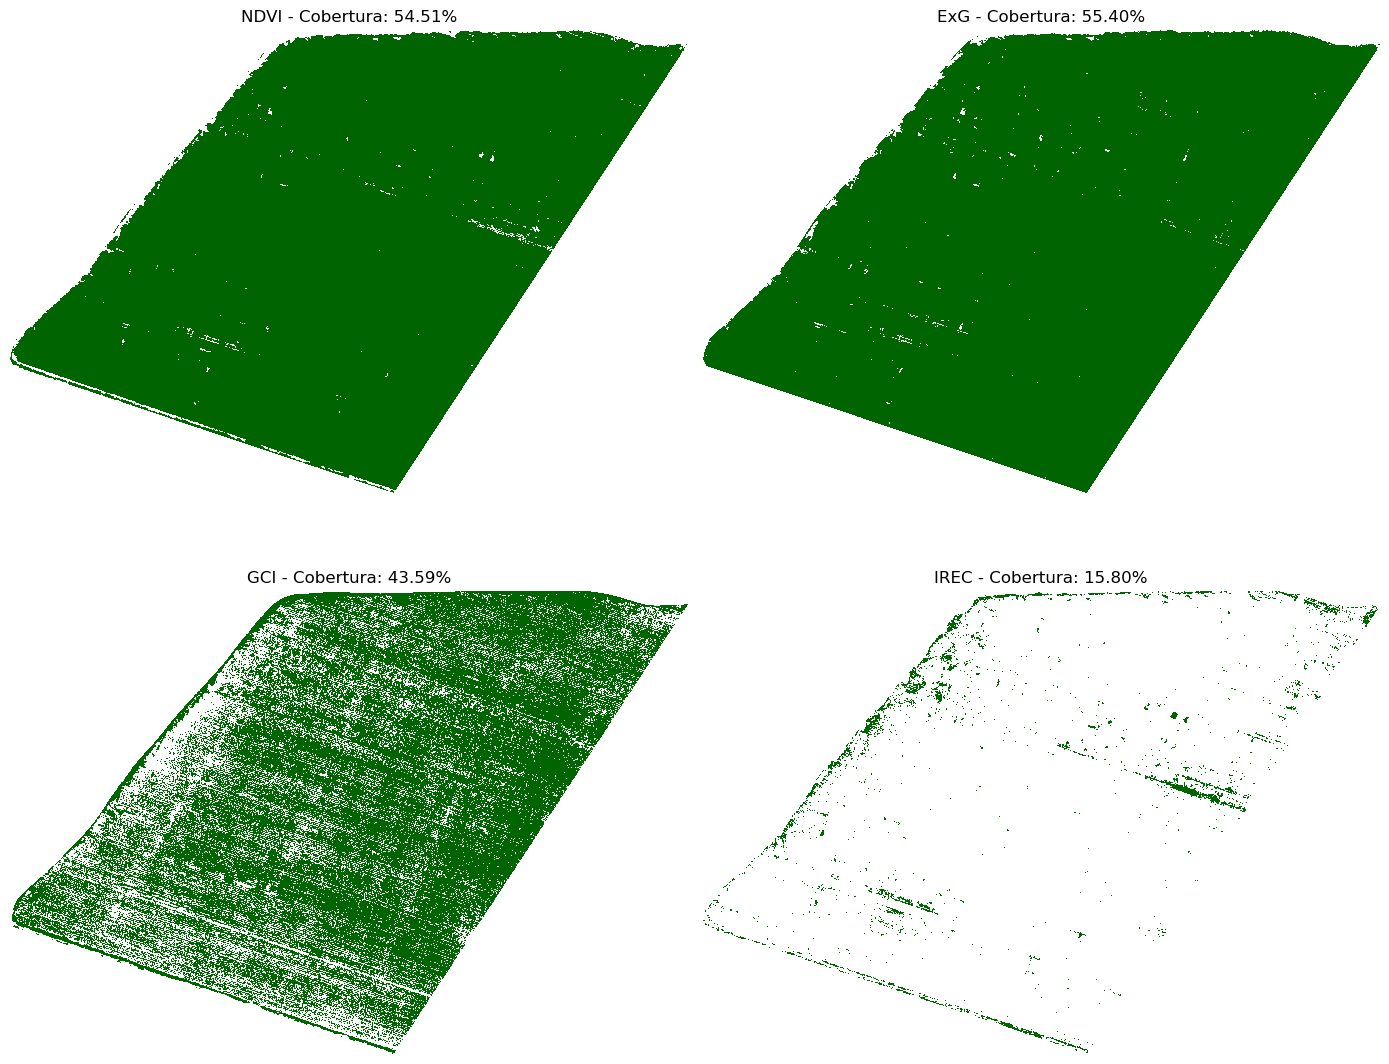

In [21]:
# === Ruta de tus archivos TIFF ===
indices_info = {
    "NDVI": {"ruta": "Indices/NDVI_290624.tif", "umbral": 0.7},
    "ExG":  {"ruta": "Indices/ExG_290624.tif",  "umbral": 0.05},
    "GCI":  {"ruta": "Indices/GCI_290624.tif",  "umbral": 0.8},
    "IREC": {"ruta": "Indices/IREC_290624.tif", "umbral": 3.5}
}

# === Crear figura de 2x2 ===
fig, axs = plt.subplots(2, 2, figsize=(14, 12))

for ax, (nombre, info) in zip(axs.flat, indices_info.items()):
    try:
        # Leer el raster
        with rasterio.open(info["ruta"]) as src:
            indice = src.read(1).astype('float32')
            if src.nodata is not None:
                indice[indice == src.nodata] = np.nan

        # Generar mapa binario
        cobertura_binaria = (indice > info["umbral"]).astype(int)

        # Calcular cobertura
        total_validos = np.sum(~np.isnan(indice))
        total_vegetacion = np.sum(cobertura_binaria)
        porcentaje = (total_vegetacion / total_validos) * 100 if total_validos > 0 else 0

        # Mostrar
        ax.imshow(cobertura_binaria, cmap=ListedColormap(["#ffffff", "#006400"]))
        ax.set_title(f"{nombre} - Cobertura: {porcentaje:.2f}%", fontsize=12)
        ax.axis("off")

    except Exception as e:
        ax.set_title(f"{nombre} - Error al cargar")
        ax.axis("off")
        print(f"Error con {nombre}: {e}")

plt.tight_layout()
plt.show()